# Sales Prediction: Explaining Models with SHAP

by: Israel Diaz

## Description

In this part of the project we'll try to dig deeper into the models we've built in the previous part. We'll use SHAP to explain the models and try to understand what are the most important features for each model. We'll also try to understand how the models are making their predictions.

## Model Interpretation

### Loading libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Customization Options
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'


## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn import metrics
## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)



C:\Users\diazi\AppData\Local\Temp\ipykernel_87464\1746424605.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['fivethirtyeight','seaborn-talk'])


### Loading models

As in the previous notebook I saved the models in a joblib file. I'll load the models and the data from the joblib file.

In [3]:
loaded_joblib = joblib.load('models/random_forrest_tuned.joblib')

## the file is called random_forrest_tuned but it's actually a both models linear regression and random forrest

In [5]:
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForest', 'LinearRegression'])

In [6]:
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
rf_model = loaded_joblib['RandomForest']
lr_model = loaded_joblib['LinearRegression']

In [7]:
X_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.712775,1.828109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.556340,-1.291052,0.603369,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.131512,1.813319,0.244541,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.169219,-1.004931,-0.952591,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.528819,-0.965484,-0.336460,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [8]:
y_train.head()

4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
Name: Item_Outlet_Sales, dtype: float64

### Explaining the Random Forrest Model using SHAP

In [9]:
len(X_train)

6392

We have 6392 observations in our training set. We'll use 1000 of them to explain the model.

In [10]:
## Loading the shap library
import shap
shap.initjs()

In [12]:
## Sample data
X_shap = shap.sample(X_train, nsamples=1000, random_state=42)
X_shap

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
2937,-1.076715e+00,-0.512371,0.787847,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6371,-7.612518e-01,-0.696180,1.266775,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3762,1.030720e+00,-1.291052,-1.667054,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
419,1.445803e+00,-0.760232,-0.233883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8475,1.350927e+00,0.285949,-0.789418,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-9.593343e-02,0.731825,0.446542,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1560,4.213344e-16,3.093650,0.429564,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2949,4.213344e-16,0.958907,-1.340625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6243,-4.279997e-01,-1.291052,-0.365161,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


We have to consider that the data is scaled.

In [13]:
y_shap = y_train.loc[X_shap.index]
y_shap

2937    2285.0256
6371    2217.1140
3762     196.4110
419     2940.1728
8475     378.1744
          ...    
455     2897.5616
1560     167.7816
2949    2143.2102
6243    1303.6364
1351      89.8830
Name: Item_Outlet_Sales, Length: 1000, dtype: float64

In [14]:
## Loading explainer
explainer = shap.Explainer(rf_model)
explainer

In [15]:
shap_values = explainer(X_shap,y_shap)
shap_values.shape

(1000, 32)

Now we plot the summary_plot. This plot shows the most important features for the model. The features are ordered by the magnitude of the effect on the model output. The color represents the feature value (red high, blue low).

### Summary plot with bars

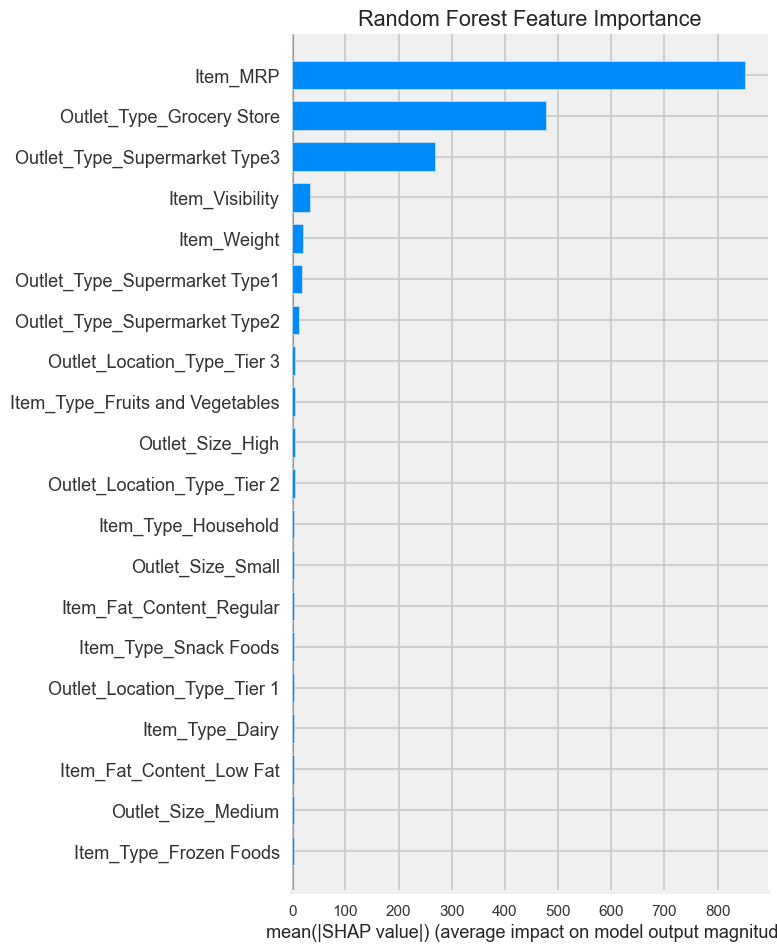

In [20]:
## Plotting the summary plot for the random forrest model
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, show=False, plot_type='bar')
ax.set_title('Random Forest Feature Importance')
fig.savefig('imgs/shap_feature_importance_bar.png')

The feature importance from the past analysis looked like this:

![png](imgs/feature_importance.png)

We can see that the most important features are the same (5 most important ones). The only difference is that the feature importance from the past analysis was based on the mean decrease in impurity. The SHAP summary plot is based on the magnitude of the effect on the model output. The SHAP summary plot is more accurate because it takes into account the interaction between the features.

### Summary plot with dots

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


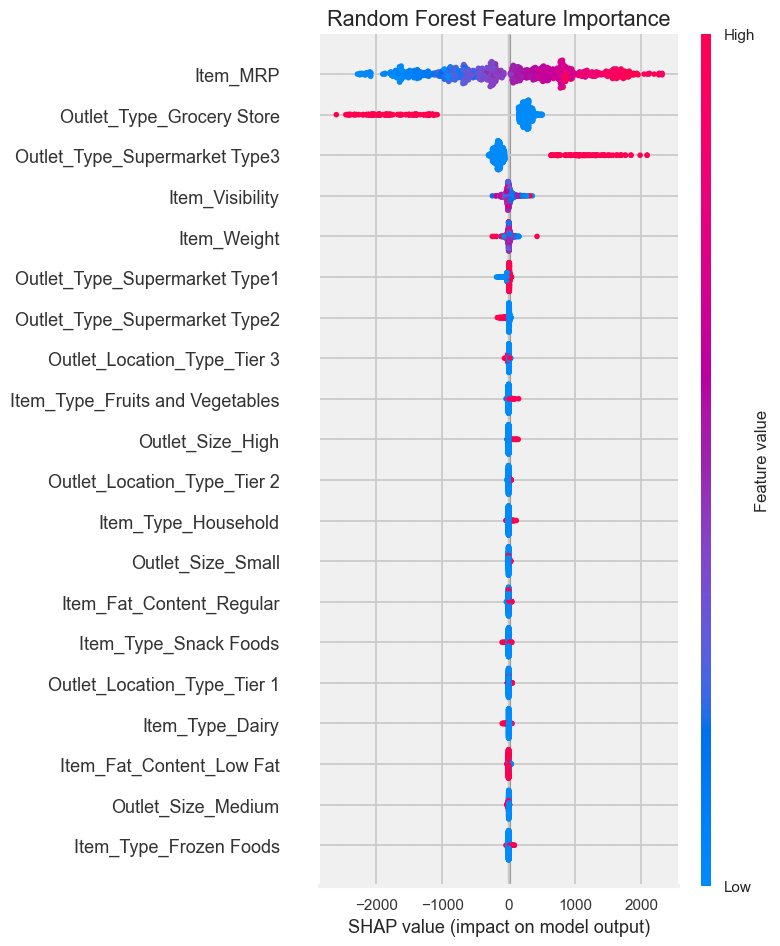

In [21]:
## plotting the summary plot for the random forrest model with dots.
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, show=False, plot_type='dot')
ax.set_title('Random Forest Feature Importance')
fig.savefig('imgs/shap_feature_importance_dot.png')

The 3 most important features can be interprted as follows:

| Feature                            | Interpretation                                                                                                                        |
|------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------|
| **Item_MRP:**                      | As the red dots are on the right side of the plot, we can see that the higher the MRP of the item, the higher the sales.              |
| **Outlet_Type_Grocery Store:**     | As the red dots are on the left side of the plot, we can see that the model is likely to predict lower sales for grocery stores.      |
| **Outlet_Type_Supermarket Type3:** | As the red dots are on the right side of the plot, we can see that the model is likely to predict higher sales for Supermarket Type3. |